# rewrite loading xyz using ase

In [20]:
import py3Dmol
import numpy as np
import matplotlib.pyplot as plt
# from IPython.display import display
from ipyfilechooser import FileChooser
import re

%matplotlib widget

def calculate_distance(coord1, coord2):
    return np.sqrt((coord2[0] - coord1[0])**2 + (coord2[1] - coord1[1])**2 + (coord2[2] - coord1[2])**2)

def cluster_size_calc(elements, coordinates, printit=True):
    distance_to_center = []
    for coord_i in coordinates:
        distance_to_center.append(calculate_distance(coord_i, [0,0,0]))
    distance_to_center = np.array(distance_to_center)   
    if printit:
        print(f"cluster size:{distance_to_center.max()  } A")
    return distance_to_center, distance_to_center.max()

def shrink_cluster(elements, coordinates, radius):
    print(f"Reduce cluster size to less than {radius}")
    print("Old cluster size is")
    distances_all, size = cluster_size_calc(elements, coordinates)
    indices = np.where(distances_all < radius)[0]
    elements_shrinked = [elements[i] for i in indices]
    coordinates_shrinked = [coordinates[i] for i in indices]
    print("New cluster size is")    
    distances_all, size = cluster_size_calc(elements_shrinked, coordinates_shrinked )

    return list(elements_shrinked), coordinates_shrinked


## Examples

In [17]:
def read_file():
    if fc.selected is not None:
        with open(fc.selected, 'r') as file:
            content = file.read()
        return content
    else:
        print("No file selected.")

fc = FileChooser()
display(fc)


FileChooser(path='/Users/juanjuanhuang/Desktop/neighbor', filename='', title='', show_hidden=False, select_des…

In [19]:
from ase.io import read

# Load the XYZ file
atoms = read(fc.value)

# Now you can work with the 'atoms' object
print(atoms)

Atoms(symbols='O4PbO4PbO7PbO4Pb2O8PbO4Pb2O7Pb2O4Pb2O2Pb3', pbc=False)


In [ ]:
atoms.get_global_number_of_atoms()
atoms.get_chemical_formula()
atoms.get

'O44Pb15'

In [ ]:
class ClusterNeighbor(object):
    def __init__(self):
        pass

    def load_xyz(self, xyz_path):
        self.atoms = read(fc.value)
        
        self.xyz_string = f"{len(self.atoms)}\n\n" 
        for atom in atoms:
            self.xyz_string += f"{atom.symbol} {atom.position[0]} {atom.position[1]} {atom.position[2]}\n"
    
    def view_xyz(self, style_all=None, highlight_atom1="O", highlight_atom2="Pb", label=True):
        self.view = py3Dmol.view(width=500,height=500)
        self.view.addModel(self.xyz_string,'xyz',)
        if style_all is None:
            style_all = {'stick':{'radius':.1, 'alpha':0.2, 'color':'gray'}, 
                                  'sphere': {'radius':.3}
                                 }
        self.view.setStyle(style_all)
        
        self.view.addStyle({'atom': highlight_atom1}, 
                        {'sphere': {'color': 'red', 'radius': 0.5}})  
        
        self.view.addStyle({'atom': highlight_atom2}, 
                           {'sphere': {'color': 'blue', 'radius': 0.3}})  
        self.view.setBackgroundColor('0xeeeeee')
        if label:
            for i, atom_i in enumerate(self.atoms):
                self.view.addLabel(f"{i}", {'position': {'x': atom_i.position[0], 'y': atom_i.position[1], 'z': atom_i.position[2]}, 
                                    'fontColor': 'k', 'fontSize': 12, 'backgroundColor': 'white', 'backgroundOpacity':0.5})
        self.view.zoomTo()
        self.view.show()
        self.view.title(self.atoms.get_chemical_formula())
    
    def get_cluster_size(self):
        self.cluster_size = self.atoms.get_all_distances().max()/2
        print(f"Cluster size is {self.cluster_size} A")
        return self.cluster_size
    

test = ClusterNeighbor()
test.load_xyz(fc.value)
test.view_xyz(highlight_atom1="Pb", highlight_atom2="O", label=True)
test.get_cluster_size()
test.atoms.get_angle(30, 52,35)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Cluster size is 5.926372577426853 A


102.77121264954359

In [21]:
xyz = test.xyz_string
xyzview = py3Dmol.view(width=400,height=400)
xyzview.addModel(xyz,'xyz',)
xyzview.setStyle({'stick':{'radius':.1, 'alpha':0.2, 'color':'gray'}, 
                  'sphere': {'radius':.3}
                  }
                 )

xyzview.addStyle({'atom': 'O'}, 
                 {'sphere': {'color': 'blue', 'radius': 0.3}})  

xyzview.addStyle({'atom': 'Pb'}, 
                 {'sphere': {'color': 'red', 'radius': 0.5}})  

xyzview.setBackgroundColor('0xeeeeee')
xyzview.zoomTo()
xyzview.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [22]:
compound = xyz.split('\n')[2:-1]
xyz_sorted = [compound[i].split(" ") for i in range(len(compound))]
elements = [xyz_sorted[i][0] for i in range(len(compound))]

coordinates = [np.array([float(xyz_sorted[i][1]),
                         float(xyz_sorted[i][2]), 
                         float(xyz_sorted[i][3])]) for i in range(len(compound))]


num_atoms = len(elements)
output = {"unique_pairs_all":{},
          "pairs_all":[],
          "unique_element":list(set(elements)),
          "element_num":{},
          "bond_num":{}
          }

for i in range(num_atoms):
    atom_i = elements[i]
    atom_unique_i = f"{elements[i]}({i:d})"
    for j in range(num_atoms):
        if j !=i:
            atom_j = elements[j]
            atom_unique_j = f"{elements[j]}({j:d})"
            distance = calculate_distance(coordinates[i], coordinates[j])
            output['pairs_all'].append(f"{atom_i}-{atom_j}")
            output['unique_pairs_all'][f"{atom_unique_i}-{atom_unique_j}"] = distance
            # print(f"{atom_unique_i}-{atom_unique_j}: {distance} Å")

output["bond_types"] = list(set(output['pairs_all']))

for element_i in output["unique_element"]:
    output['element_num'][element_i] = elements.count(element_i)


bond_type = output["bond_types"]

for bond_i in output["bond_types"]:
    # print(bond_i)
    element1, element2 = bond_i.split("-")
    pattern = rf'{element1}\(\d+\)-{element2}\(\d+\)'
    output[f"{bond_i}_num"] = {}
    for key_i in output['unique_pairs_all'].keys():
        if re.match(pattern, key_i):
            output[f"{bond_i}_num"][key_i] = output['unique_pairs_all'][key_i]


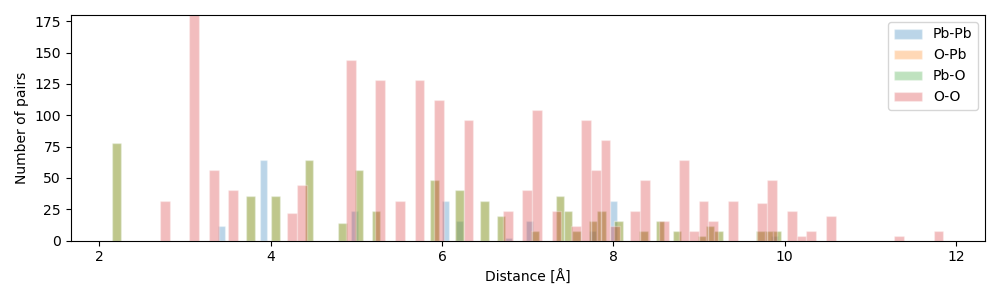

In [23]:
plt.figure(figsize=(10,3))
for key_i in output['bond_types']:
    plt.hist(output[f"{key_i}_num"].values(), bins=80, alpha=0.3, edgecolor='white', label=key_i)
plt.xlabel("Distance [Å]")
plt.ylabel("Number of pairs")
plt.legend()
plt.ylim(0, 180)
plt.tight_layout()
plt.show()

# within 0.001 A is considered as same distance, cakculate all distances

# cluster size = longest distances/2

In [ ]:
def CN_calc(R_range=[1,3], pair=None):
    shell_distances = {}
    element = pair.split("-")[0]
    for key_i in output[f"{pair}_num"].keys():
        if R_range[0] < output[f"{pair}_num"][key_i] < R_range[1]:
            shell_distances[key_i] = output[f"{pair}_num"][key_i]
    CN_num = len(shell_distances.values())/output['element_num'][element]
    print(f"Average CN of {element} element: {CN_num}")
    average_distance = np.average(np.array(list(shell_distances.values())))
    print(f"Average distance of {pair} pair: {average_distance} \n")
    return shell_distances, average_distance


result = CN_calc(R_range=[1,5], pair="O-O")
# result = CN_calc(R_range=[3,3.1], pair="O-O")
# result = CN_calc(R_range=[3.3,3.1], pair="O-O")

# result = CN_calc(R_range=[2,2.16], pair="O-Pb")
# result = CN_calc(R_range=[2.16,3.7], pair="O-Pb")

NameError: name 'output' is not defined

In [ ]:
from operator import itemgetter

data = output["Pb-O_num"]

# Sort the dictionary by its values
sorted_items = sorted(data.items(), key=itemgetter(1))
sorted_data = dict(sorted_items)

print(sorted_dict)

NameError: name 'output' is not defined

In [ ]:
my_dict = {"a": 3, "b": 1, "c": 2}

# Sort the dictionary by its values and create a new dictionary
sorted_dict = {k: v for k, v in sorted(my_dict.items(), key=lambda item: item[1])}

print(sorted_dict)


{'b': 1, 'c': 2, 'a': 3}


In [ ]:
sorted(my_dict.items())

[('a', 3), ('b', 1), ('c', 2)]

In [ ]:
from operator import itemgetter

my_dict = {"a": 3, "b": 1, "c": 2}

# Sort the dictionary by its values
sorted_items = sorted(my_dict.items(), key=itemgetter(1))

# Create a new dictionary from the sorted items
sorted_dict = dict(sorted_items)

print(sorted_dict)


{'b': 1, 'c': 2, 'a': 3}


In [ ]:
output["Pb-O_num"]

{'Pb(4)-O(0)': 2.169284686124207,
 'Pb(4)-O(1)': 2.169284331459341,
 'Pb(4)-O(2)': 2.15345086394582,
 'Pb(4)-O(3)': 2.153451309638553,
 'Pb(4)-O(5)': 2.169284307187511,
 'Pb(4)-O(6)': 2.1692843308063607,
 'Pb(4)-O(7)': 4.016148357495276,
 'Pb(4)-O(8)': 4.016148556131109,
 'Pb(4)-O(10)': 5.262127817255393,
 'Pb(4)-O(11)': 5.262128445126459,
 'Pb(4)-O(12)': 5.062180715647062,
 'Pb(4)-O(13)': 4.450975186934319,
 'Pb(4)-O(14)': 6.229254728241574,
 'Pb(4)-O(15)': 6.659154409644666,
 'Pb(4)-O(16)': 3.7594638058720555,
 'Pb(4)-O(18)': 4.450974540037047,
 'Pb(4)-O(19)': 6.229254890838391,
 'Pb(4)-O(20)': 7.472377674128965,
 'Pb(4)-O(21)': 5.062180724054506,
 'Pb(4)-O(24)': 6.541817799478292,
 'Pb(4)-O(25)': 7.860522176635023,
 'Pb(4)-O(26)': 7.7525456975264575,
 'Pb(4)-O(27)': 5.062180419770518,
 'Pb(4)-O(28)': 4.450974896298001,
 'Pb(4)-O(29)': 6.229255208813571,
 'Pb(4)-O(30)': 3.7594644324053657,
 'Pb(4)-O(31)': 6.659154972463173,
 'Pb(4)-O(33)': 4.450975708406192,
 'Pb(4)-O(34)': 6.2292552

In [ ]:
import pandas as pd

In [ ]:
# Creating a DataFrame with hierarchical columns
df = pd.DataFrame(data={('A', 'x'): [1, 2, 3], ('A', 'y'): [4, 5, 6], ('B', 'x'): [7, 8, 9]})

print(df)


   A     B
   x  y  x
0  1  4  7
1  2  5  8
2  3  6  9


In [28]:
output['O-O_num']

{'O(0)-O(1)': 2.707597111234609,
 'O(0)-O(2)': 3.0566564529017652,
 'O(0)-O(3)': 3.0566567287356623,
 'O(0)-O(5)': 3.390000392527558,
 'O(0)-O(6)': 4.3385690169304665,
 'O(0)-O(7)': 5.685714086883459,
 'O(0)-O(8)': 5.685714073713961,
 'O(0)-O(10)': 6.77999990213171,
 'O(0)-O(11)': 7.3006497440416895,
 'O(0)-O(12)': 5.32311827041256,
 'O(0)-O(13)': 4.96000051201832,
 'O(0)-O(14)': 7.136183806928533,
 'O(0)-O(15)': 7.651558844446339,
 'O(0)-O(16)': 5.323117663638387,
 'O(0)-O(18)': 6.0078031218508645,
 'O(0)-O(19)': 7.900457068694886,
 'O(0)-O(20)': 9.029426473132277,
 'O(0)-O(21)': 7.163783325983974,
 'O(0)-O(24)': 8.400595718269866,
 'O(0)-O(25)': 9.8434503879724,
 'O(0)-O(26)': 9.863477158265688,
 'O(0)-O(27)': 5.323117893749959,
 'O(0)-O(28)': 4.9600001254252,
 'O(0)-O(29)': 7.13618403098841,
 'O(0)-O(30)': 5.323118008057871,
 'O(0)-O(31)': 7.651559382651747,
 'O(0)-O(33)': 6.007804068493828,
 'O(0)-O(34)': 7.90045739099813,
 'O(0)-O(35)': 7.163783217039652,
 'O(0)-O(36)': 9.02942712

In [24]:
def group_data(data, error_bar=0.01):

    sorted_items = sorted(data.items(), key=itemgetter(1))
    data_sorted = dict(sorted_items)
    diff = np.diff(data_sorted.values())
    indices = np.where(diff > error_bar)[0] + 1

    # Split the array at these indices
    return np.split(data_sorted, indices)

# Example data values
data_values = np.array(output['O-O_num'])

# Grouping the data
grouped_data = group_data(data_values)

# Print the grouped data
for group in grouped_data:
    print(group)


AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [ ]:
df

,Key,Value
570,Pb(56)-O(54),2.153451
353,Pb(46)-O(1),2.153451
2,Pb(4)-O(2),2.153451
525,Pb(53)-O(51),2.153451
644,Pb(58)-O(34),2.153451
...,...,...
633,Pb(58)-O(20),9.961182
162,Pb(22)-O(36),9.961182
629,Pb(58)-O(15),9.961182
277,Pb(37)-O(15),9.961182


In [ ]:
import pandas as pd

data_values = output["Pb-O_num"]

df = pd.DataFrame(list(data_values.items()), columns=['Key', 'Value'])
df = df.sort_values(by='Value')

# Function to group keys based on value difference threshold
def group_keys(df, threshold=0.01):
    # Create an empty list to store groups
    groups = []
    current_group = [df.iloc[0]['Key']]

    for i in range(1, len(df)):
        # Check if the current value is within the threshold of the previous value
        if abs(df.iloc[i]['Value'] - df.iloc[i-1]['Value']) <= threshold:
            current_group.append(df.iloc[i]['Key'])
        else:
            # If not, add the current group to groups and start a new group
            groups.append(current_group)
            current_group = [df.iloc[i]['Key']]

    # Add the last group to groups
    groups.append(current_group)

    return groups

# Grouping the keys
grouped_keys = group_keys(df)

# Print the grouped keys
# for group in grouped_keys:
    # print(group)


In [ ]:
elements_shinked, coordinates_shrinked = shrink_cluster(elements, coordinates, radius=5)

Reduce cluster size to less than 5
Old cluster size is
cluster size:5.926372577426853 A
New cluster size is
cluster size:4.960000322044647 A


In [ ]:
elements = elements_shinked
coordinates = coordinates_shrinked
num_atoms = len(elements)
output = {"unique_pairs_all":{},
          "pairs_all":[],
          "unique_element":list(set(elements)),
          "element_num":{},
          "bond_num":{}
          }

for i in range(num_atoms):
    atom_i = elements[i]
    atom_unique_i = f"{elements[i]}({i:d})"
    for j in range(num_atoms):
        if j !=i:
            atom_j = elements[j]
            atom_unique_j = f"{elements[j]}({j:d})"
            distance = calculate_distance(coordinates[i], coordinates[j])
            output['pairs_all'].append(f"{atom_i}-{atom_j}")
            output['unique_pairs_all'][f"{atom_unique_i}-{atom_unique_j}"] = distance
            # print(f"{atom_unique_i}-{atom_unique_j}: {distance} Å")

output["bond_types"] = list(set(output['pairs_all']))
for element_i in output["unique_element"]:
    output['element_num'][element_i] = elements.count(element_i)


bond_type = output["bond_types"]

for bond_i in output["bond_types"]:
    # print(bond_i)
    element1, element2 = bond_i.split("-")
    pattern = rf'{element1}\(\d+\)-{element2}\(\d+\)'
    output[f"{bond_i}_num"] = {}
    for key_i in output['unique_pairs_all'].keys():
        if re.match(pattern, key_i):
            output[f"{bond_i}_num"][key_i] = output['unique_pairs_all'][key_i]



NameError: name 'elements_shinked' is not defined

NameError: name 'output' is not defined

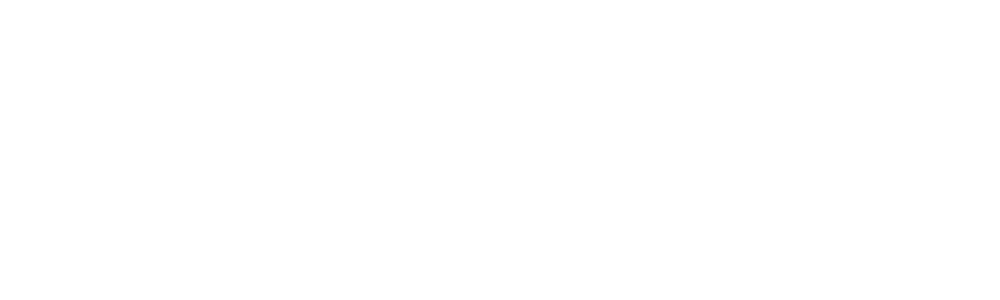

In [ ]:
plt.figure(figsize=(10,3))
for key_i in output['bond_types']:
    plt.hist(output[f"{key_i}_num"].values(), bins=80, alpha=0.3, edgecolor='white', label=key_i)
plt.xlabel("Distance [Å]")
plt.ylabel("Number of pairs")
plt.legend()
plt.ylim(0, 180)
plt.tight_layout()
plt.show()

In [ ]:
def CN_calc(R_range=[1,3], pair=None):
    shell_distances = {}
    element = pair.split("-")[0]
    for key_i in output[f"{pair}_num"].keys():
        if R_range[0] < output[f"{pair}_num"][key_i] < R_range[1]:
            shell_distances[key_i] = output[f"{pair}_num"][key_i]
    CN_num = len(shell_distances.values())/output['element_num'][element]
    print(f"Average CN of {element} element: {CN_num}")
    average_distance = np.average(np.array(list(shell_distances.values())))
    print(f"Average distance of {pair} pair: {average_distance} \n")
    return shell_distances, average_distance


result = CN_calc(R_range=[1,3], pair="O-O")
result = CN_calc(R_range=[3,3.1], pair="O-O")
result = CN_calc(R_range=[3.3,3.1], pair="O-O")

result = CN_calc(R_range=[2,2.16], pair="Pb-O")
result = CN_calc(R_range=[2.16,3.7], pair="Pb-O")

Average CN of O element: 0.5
Average distance of O-O pair: 2.7075967202365288 

Average CN of O element: 4.666666666666667
Average distance of O-O pair: 3.0566561615325583 

Average CN of O element: 0.0
Average distance of O-O pair: nan 

Average CN of Pb element: 1.4666666666666666
Average distance of Pb-O pair: 2.1534512655535285 

Average CN of Pb element: 2.4
Average distance of Pb-O pair: 2.1692843627039164 



75/number of Pd num_atoms (coordinations )

1. CN of Pd atoms, CN of Oxygen
2. calculate radius of the cluster: longest distance from (0,0,0)
3. increase radius of the cluster, doesn't need to shrink/expand the bond lengths, chop the hist and calculate the CN again
4. cif file --> cluster, increase clusters

Display local file.

In [ ]:
benz='''
     RDKit          3D

  6  6  0  0  0  0  0  0  0  0999 V2000
   -0.9517    0.7811   -0.6622 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.2847    1.3329   -0.3121 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.2365    0.5518    0.3512 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.9517   -0.7811    0.6644 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.2847   -1.3329    0.3144 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.2365   -0.5518   -0.3489 C   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  2  0
  2  3  1  0
  3  4  2  0
  4  5  1  0
  5  6  2  0
  6  1  1  0
M  END
$$$$'''
view = py3Dmol.view(data=benz,
                    style={'stick':{'colorscheme':'cyanCarbon'}},
                    width=400,height=200
                    )
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You can create a single canvas object with multiple viewers arrayed in a grid (3Dmol.createViewerGrid).

In [ ]:
view = py3Dmol.view(query='pdb:1dc9',linked=False,viewergrid=(2,2))
view.setViewStyle({'style':'outline','color':'black','width':0.1})
view.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}},viewer=(0,1))
view.setStyle({'stick':{'colorscheme':'greenCarbon'}},viewer=(1,0))
view.setStyle({'cartoon':{'color':'spectrum'}},viewer=(1,1))
view.removeAllModels(viewer=(0,0))
view.addModel(benz,'sdf',viewer=(0,0))
view.setStyle({'stick':{}},viewer=(0,0))
view.zoomTo(viewer=(0,0))
view.render()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
view = py3Dmol.view(query='pdb:1ycr')
chA = {'chain':'A'}
chB = {'chain':'B'}
view.setStyle(chA,{'cartoon': {'color':'spectrum'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.7,'color':'white'}, chA)
view.setStyle(chB,{'stick':{}})
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
view = py3Dmol.view(query='pdb:5ire',options={'doAssembly':True})
view.setStyle({'cartoon':{'color':'spectrum'}})
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Color by temperature factors

In [ ]:
view = py3Dmol.view(query='pdb:1ycr')
view.setStyle({'cartoon': {'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.7,'colorscheme':{'prop':'b','gradient':'sinebow','min':0,'max':70}})

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
import requests, base64
r = requests.get('https://mmtf.rcsb.org/v1.0/full/5lgo')
view = py3Dmol.view()
view.addModel(base64.b64encode(r.content).decode(),'mmtf')
view.addUnitCell()
view.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Specifying individual styles for a viewer grid in the constructor

In [ ]:
view = py3Dmol.view(query='pdb:1dc9',viewergrid=(2,2),style=[[{'stick':{}},{'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}}],
                                                            [{'stick':{'colorscheme':'greenCarbon'}},{'cartoon':{'color':'spectrum'}}]])
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

It isn't possible to convert Python functions to Javascript functions, but Javascript code can be provided in string form to click/hover callbacks.

In [ ]:
v = py3Dmol.view(query="pdb:1ubq",style={'cartoon':{},'stick':{}})
v.setHoverable({},True,'''function(atom,viewer,event,container) {
                   if(!atom.label) {
                    atom.label = viewer.addLabel(atom.resn+":"+atom.atom,{position: atom, backgroundColor: 'mintcream', fontColor:'black'});
                   }}''',
               '''function(atom,viewer) {
                   if(atom.label) {
                    viewer.removeLabel(atom.label);
                    delete atom.label;
                   }
                }''')

An existing viewer can be modified from different cells with `update`

In [ ]:
benz='''
     RDKit          3D

  6  6  0  0  0  0  0  0  0  0999 V2000
   -0.9517    0.7811   -0.6622 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.2847    1.3329   -0.3121 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.2365    0.5518    0.3512 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.9517   -0.7811    0.6644 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.2847   -1.3329    0.3144 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.2365   -0.5518   -0.3489 C   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  2  0
  2  3  1  0
  3  4  2  0
  4  5  1  0
  5  6  2  0
  6  1  1  0
M  END
$$$$'''
view = py3Dmol.view()
view.addModel(benz,'sdf')
view.setStyle({'stick':{}})
view.zoomTo()
view.show()

However, **this does not work in colab** because colab sandboxes the JavaScript environments of each cell.

In [ ]:
view.setStyle({'stick':{'color':'blue'}})
view.update()

In [ ]:
p = py3Dmol.view(query='mmtf:1ycr')
p.setStyle({'cartoon': {'color':'spectrum'}})
p

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol